In [1]:
import numpy as np
import pandas as pd
import scipy
import yaml
import btrdb

from datetime import datetime, timedelta

from scipy import signal
from scipy.fft import fftshift

import matplotlib.colors as colors
from matplotlib import pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

In [5]:
# Make sure you add your API key to the config file to connect!
with open('../my_config.yaml', 'r') as f:
    config = yaml.safe_load(f)

url = 'api.ni4ai.org:4411'
api_key = config['connection']['api_key']
    
db = btrdb.connect(url, api_key)

{'connection': {'api_key': '2301C47D67FB1C2C48D0CC7B', 'api_url': 'api.ni4ai.org:4411'}}


In [27]:
streams = db.streams_in_collection('monitoring/generator4')
for i, s in enumerate(streams):
    print(i, s.name)

0 PhA_Vmag
1 PhB_Vmag
2 PhC_Vmag
3 PhA_Cmag
4 PhB_Cmag
5 PhC_Cmag
6 P
7 Freq
8 Q
9 PhA_Vang
10 PhB_Vang
11 PhC_Vang
12 PhA_Cang
13 PhB_Cang
14 PhC_Cang


In [28]:
start, _ = streams[0].earliest()
end, _ = streams[0].latest()
start = start.time
end = end.time

days = pd.date_range(start=btrdb.utils.timez.ns_to_datetime(start), 
                     end=btrdb.utils.timez.ns_to_datetime(end), 
                     freq='D',)
print(days[0], days[-1])

2020-09-19 00:00:00+00:00 2020-09-26 00:00:00+00:00


In [80]:
pw = 38 # 2**41 ns or about 4.28 hours
dt = 2**pw
sample_rate = 30 # measurements per second
print('window=%.2f min'%(2**pw/1e9/60))

window=4.58 min


In [81]:
freq, tx, Sxx = signal.spectrogram(np.ones(int(1e4)), sample_rate)
result = pd.DataFrame(index=freq)


In [82]:
def find_gaps(df, sample_rate=120):
    diff = df['time'].diff()
    gaps = df['time'][diff > 1.1*1e9/sample_rate].tolist()
    if len(gaps) == 0:
        return df
    else:
        # to do: write helper function to fill in gaps
        print('gaps!')
        return pd.DataFrame(np.zeros(df.shape), columns=df.keys())

d = days[0]
t0 = datetime.now()

start = btrdb.utils.timez.datetime_to_ns(d)
end = btrdb.utils.timez.datetime_to_ns(d+timedelta(days=1))

statpoints, _ = zip(*s.aligned_windows(start, end, pw))
for j, point in enumerate(statpoints):

    t = point.time
    if t in result.keys():
        # skip if time t is already processed
        continue

    points, _ = zip(*s.values(t, t+dt))
    df = pd.DataFrame([(p.time, p.value) for p in points],
                      columns=['time','value'])

    df = find_gaps(df, sample_rate=sample_rate)

    if df.sum().sum()==0:
        result[t] = np.nan
    else:
        freq, time, Sxx = signal.spectrogram(df['value'], sample_rate)
        spectrotimes = np.linspace(df['time'].min(), df['time'].max(), len(time))

        for j, _t in enumerate(spectrotimes):
            result[_t] = pd.Series(Sxx[:,j], index=freq)


2020-09-19 00:00:00+00:00 0 of 314


In [83]:
result[result.keys()[:5]]

,1.600474e+18,1.600474e+18,1.600474e+18,1.600474e+18,1.600474e+18
0.000000,0.014548,4.665153e-01,5.381467e-01,1.060628e-01,8.407675e-02
0.117188,3194.885366,2.989595e+03,2.394313e+03,1.930831e+03,1.699206e+03
0.234375,423.493149,4.292967e+02,3.536316e+02,2.801693e+02,2.483340e+02
0.351562,58.704012,5.795577e+01,4.840096e+01,3.965241e+01,3.812827e+01
0.468750,1.977420,1.895820e+00,1.785546e+00,1.151572e+00,1.147757e+00
...,...,...,...,...,...
14.531250,0.000245,3.157760e-04,5.039626e-09,6.583401e-09,8.154973e-09
14.648438,0.000117,9.157376e-05,3.918950e-09,8.490435e-10,3.213674e-09
14.765625,0.000070,9.937593e-05,7.249287e-09,4.760877e-09,2.998726e-09
14.882812,0.000086,3.904778e-04,1.327299e-09,4.433297e-09,5.550428e-09


Text(0, 0.5, 'Frequency (Hz)')

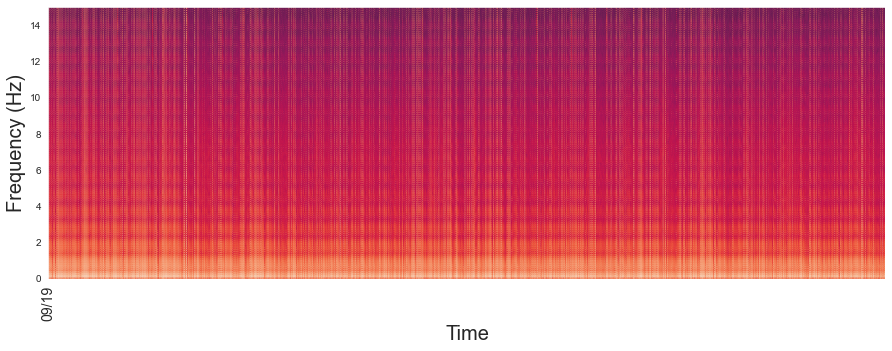

In [84]:
tstamps = [btrdb.utils.timez.ns_to_datetime(_t) for _t in result.keys()]

plt.figure(figsize=(15,5))
plt.pcolormesh(tstamps, result.index, np.array(result), shading='gouraud', norm=colors.LogNorm())

xticks = pd.date_range(start=tstamps[0].date(), end=tstamps[-1].date(), freq='D')
plt.xticks(ticks=xticks, labels=[x.strftime('%m/%d') for x in xticks], rotation=90, fontsize=14)
plt.ylim(result.index[0], result.index[-1])
plt.xlabel('Time', fontsize=20)
plt.ylabel('Frequency (Hz)', fontsize=20)



/Users/laureldunn/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  if __name__ == '__main__':


Text(0, 0.5, 'Frequency (Hz)')

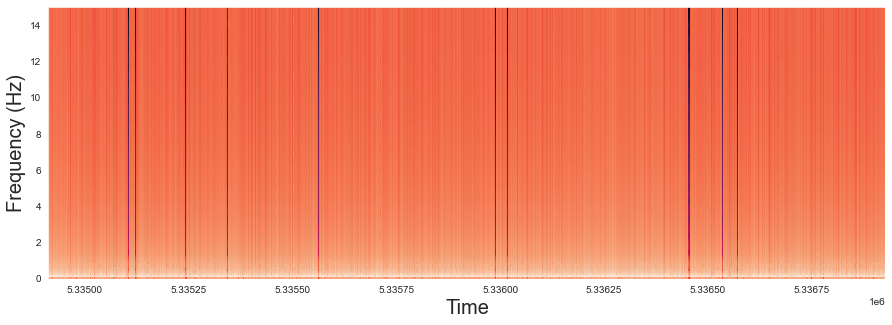

In [77]:
tstamps = [btrdb.utils.timez.ns_to_datetime(_t) for _t in result.keys()]

groups = pd.DataFrame(np.array(result).T, index=result.keys(), columns=result.index)
groups = groups.rolling(10)

plt.figure(figsize=(15,5))
plt.pcolormesh(avgs.index, avgs.keys(), np.array(avgs).T, norm=colors.LogNorm())

xticks = pd.date_range(start=tstamps[0].date(), end=tstamps[-1].date(), freq='D')
# plt.xticks(ticks=xticks, labels=[x.strftime('%m/%d') for x in xticks], rotation=90, fontsize=14)
# plt.ylim(result.index[0], result.index[-1])
plt.xlabel('Time', fontsize=20)
plt.ylabel('Frequency (Hz)', fontsize=20)



In [73]:
for key in result.keys()[:10]:
    print(key, result[key].idxmax())

1.6004736e+18 0.1171875
1.6004736076087227e+18 0.1171875
1.6004736152174454e+18 0.1171875
1.6004736228261683e+18 0.1171875
1.600473630434891e+18 0.1171875
1.6004736380436137e+18 0.1171875
1.6004736456523364e+18 0.1171875
1.600473653261059e+18 0.1171875
1.600473660869782e+18 0.1171875
1.6004736684785047e+18 0.1171875


In [48]:
(result.keys()[1]-result.keys()[0])/1e9

7.608722688